In [29]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
from d2l import torch as d2l
from IPython import display
from matplotlib import pyplot as plt
import sys
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [6]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

# 图像增广

## 常用的图像增广方法

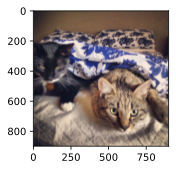

In [3]:
set_figsize()
img = Image.open('data/cat1.jpg')
d2l.plt.imshow(img)

In [9]:
#绘图函数
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数apply。这个函数对输入图像img多次运行图像增广方法aug并展示所有的结果。

In [10]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### 翻转和裁剪

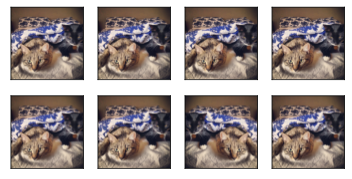

In [6]:
#左右翻转图像通常不改变物体的类别。
#它是最早也是最广泛使用的一种图像增广方法。
#下面我们通过torchvision.transforms模块
#创建RandomHorizontalFlip实例来实现一半概率的图像水平（左右）翻转。
apply(img, torchvision.transforms.RandomHorizontalFlip())

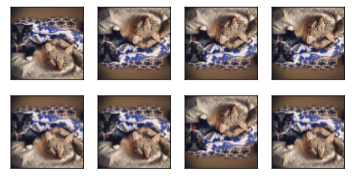

In [7]:
#上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

每次随机裁剪出一块面积为原面积$ 10\% \sim 100\%$的区域，且该区域的宽和高之比随机取自$ 0.5 \sim 2$，然后再将该区域的宽和高分别缩放到200像素。若无特殊说明，本节中aa和bb之间的随机数指的是从区间[a,b]中随机均匀采样所得到的连续值。

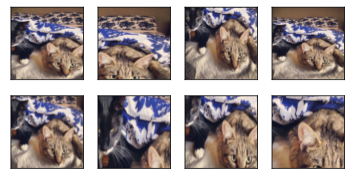

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 变化颜色
我们可以从4个方面改变图像的颜色：亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。在下面的例子里，我们将图像的亮度随机变化为原图亮度的$50\%(1-0.5)\sim 150\%(1+0.5)$。

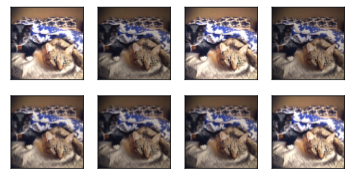

In [9]:
#改变亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

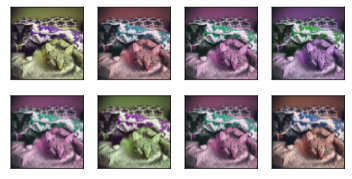

In [10]:
#改变色调
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

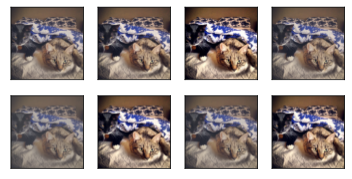

In [11]:
#改变对比度
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

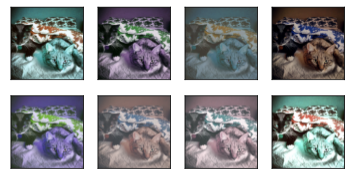

In [12]:
# 同时设置亮度，对比度，饱和度，色调
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 叠加多个图像增广方法

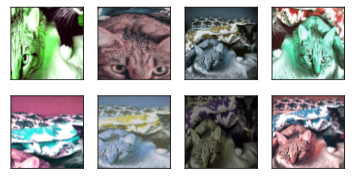

In [13]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])
apply(img, augs)

## 使用图像增广训练模型
下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用CIFAR-10数据集，而不是之前我们一直使用的Fashion-MNIST数据集。这是因为Fashion-MNIST数据集中物体的位置和尺寸都已经经过归一化处理，而CIFAR-10数据集中物体的颜色和大小区别更加显著。下面展示了CIFAR-10数据集中前32张训练图像。

Files already downloaded and verified


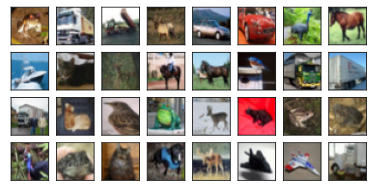

In [14]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="./data/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

In [15]:
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])

no_aug = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])

In [16]:
#定义一个辅助函数来方便读取图像并应用图像增广
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="./data/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

## 使用图像增广训练模型

In [11]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


In [12]:
#定义train_with_data_aug函数使用图像增广来训练模型了
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=5)

In [19]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.5450, train acc 0.442, test acc 0.541, time 331.0 sec
epoch 2, loss 0.4696, train acc 0.666, test acc 0.696, time 329.1 sec
epoch 3, loss 0.2315, train acc 0.758, test acc 0.722, time 329.1 sec
epoch 4, loss 0.1409, train acc 0.804, test acc 0.740, time 329.1 sec
epoch 5, loss 0.0937, train acc 0.839, test acc 0.790, time 328.9 sec


# 微调

## 获取数据集

In [7]:
data_dir = './data'
os.listdir(os.path.join(data_dir, "hotdog")) # ['train', 'test']

['test', 'train']

In [8]:
#创建两个ImageFolder实例来分别读取训练数据集和测试数据集中的所有图像文件
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

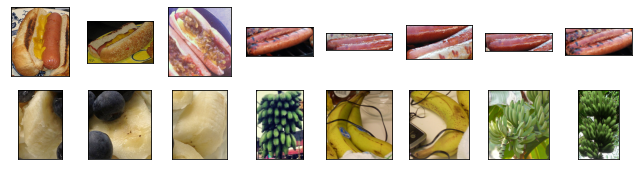

In [13]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(8)]
show_images(hotdogs+not_hotdogs, 2, 8, scale=1.4)

In [14]:
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])


## 定义和初始化模型

In [15]:
#在 home/.torch下
pretrained_net = models.resnet18(pretrained=True)

In [16]:
#下面打印源模型的成员变量fc。
#作为一个全连接层，它将ResNet最终的全局平均池化层输出变换成ImageNet数据集上1000类的输出。
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [17]:
#可见此时pretrained_net最后的输出个数等于目标数据集的类别数1000。
#所以我们应该将最后的fc成修改我们需要的输出类别数:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


此时，pretrained_net的fc层就被随机初始化了，但是其他层依然保存着预训练得到的参数。由于是在很大的ImageNet数据集上预训练的，所以参数已经足够好，因此一般只需使用较小的学习率来微调这些参数，而fc中的随机初始化参数一般需要更大的学习率从头训练。PyTorch可以方便的对模型的不同部分设置不同的学习参数，我们在下面代码中将fc的学习率设为已经预训练过的部分的10倍。

In [18]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                       {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                       lr=lr, weight_decay=0.001)

## 微调模型

In [20]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs),
                            batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                           batch_size)
    loss = torch.nn.CrossEntropyLoss()
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)


In [23]:
train_fine_tuning(pretrained_net, optimizer)

training on  cpu
epoch 1, loss 3.7291, train acc 0.679, test acc 0.890, time 168.0 sec
epoch 2, loss 0.1407, train acc 0.916, test acc 0.912, time 160.1 sec
epoch 3, loss 0.0757, train acc 0.927, test acc 0.916, time 161.0 sec
epoch 4, loss 0.1077, train acc 0.893, test acc 0.927, time 160.3 sec
epoch 5, loss 0.0295, train acc 0.944, test acc 0.938, time 165.9 sec


# 目标检测和边界框

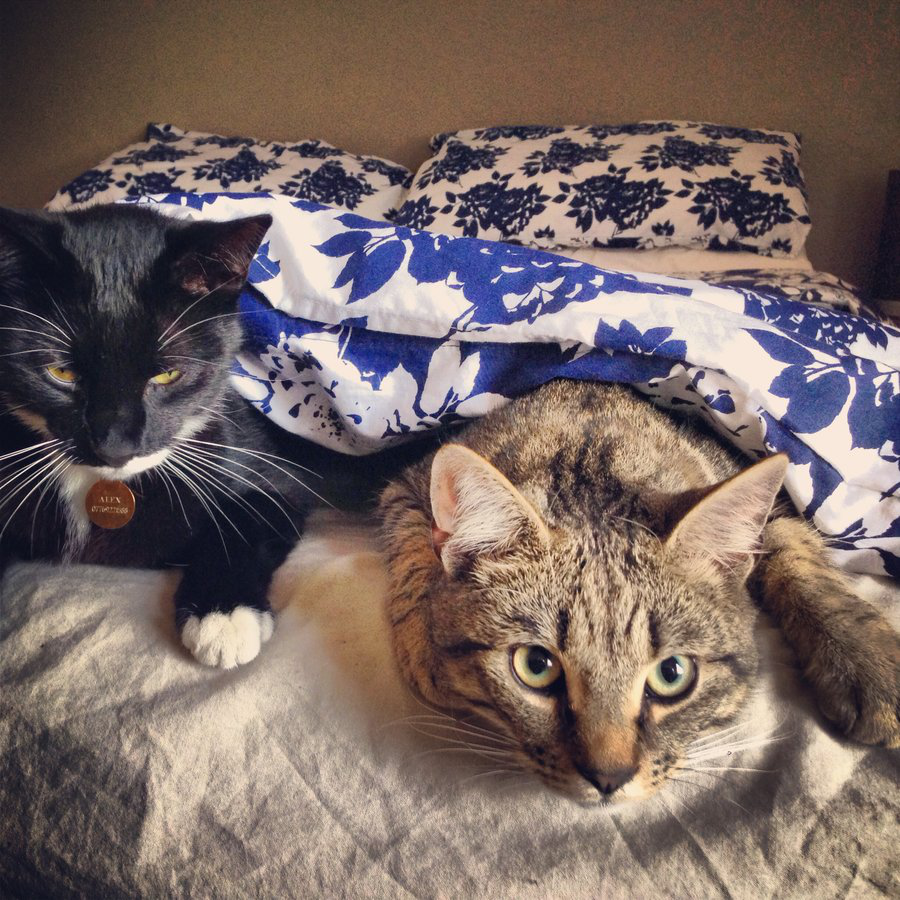

In [27]:
img = Image.open('./data/cat1.jpg')
img

In [30]:
set_figsize()
img = Image.open('./data/cat1.jpg')
w, h = img.size
print("w = %d, h = %d" % (w, h)) # w = 728, h = 561

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) of generated MultiBoxPriores. 
        ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
    Returns:
        anchors of shape (1, num_anchors, 4). 由于batch里每个都一样, 所以第一维为1
    """
    pairs = [] # pair of (size, sqrt(ration))
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])

    pairs = np.array(pairs)

    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ration)

    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2

    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)

    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))

    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)


X = torch.Tensor(1, 3, h, w)  # 构造输入数据
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape # torch.Size([1, 2042040, 4])


w = 900, h = 900


torch.Size([1, 4050000, 4])

In [31]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]# * torch.tensor([w, h, w, h], dtype=torch.float32)

tensor([-0.0972, -0.0972,  0.6528,  0.6528])

In [32]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))


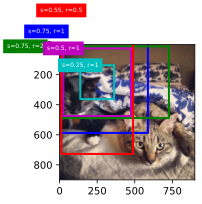

In [33]:
d2l.set_figsize()
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.75, r=2', 's=0.55, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])

In [34]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
# 参考https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py#L356
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


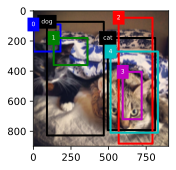

In [35]:
bbox_scale = torch.tensor((w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);


In [36]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「9.4.1. 生成多个锚框」图9.3所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 初始全为-1

    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行

    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j

    return torch.tensor(assigned_idx, dtype=torch.long)

def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]

    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]

        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels

    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])

        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)

    return [bbox_offset, bbox_mask, cls_labels]


In [37]:
labels = MultiBoxTarget(anchors.unsqueeze(dim=0),
                        ground_truth.unsqueeze(dim=0))

In [38]:
labels[2] 

tensor([[0, 1, 2, 0, 2]])

In [39]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [40]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0.0] * (4 * len(anchors)))
cls_probs = torch.tensor([[0., 0., 0., 0.,],  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

In [41]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
from collections import namedtuple
Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])

def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)

    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)

        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)

        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )

        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]

    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量

        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()

        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]

        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]

        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])

        return torch.tensor(output) # shape: (锚框个数, 6)

    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))

    return torch.stack(batch_output)


In [42]:
output = MultiBoxDetection(
    cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0), nms_threshold=0.5)
output


tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800]]])

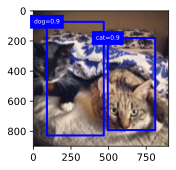

In [43]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

# 目标监测数据集（皮卡丘）

In [45]:
from mxnet import gluon, image
from mxnet.gluon import utils as gutils

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)


# 本函数已保存在d2lzh包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    data_dir = '../data/pikachu'
    #_download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
        shuffle=True,  # 以随机顺序读取数据集
        rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter


batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])
plt.show()

ModuleNotFoundError: No module named 'mxnet'